In [1]:
!pip install tensorflow
!pip install tensorflow-probability
!pip install obspy
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 48.7 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow as tf
from obspy.io.segy.segy import _read_segy
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
patch_size = 64 
batch_size = 256
num_channels = 1
num_classes = 9
all_examples = 158812
num_examples = 7500
epochs = 10
steps=250
sampler = list(range(all_examples))

opt = Adam(lr=0.001) 
lossfkt = ['categorical_crossentropy']
metrica = ['mae', 'acc']

In [4]:
filename = '/kaggle/input/pgm-data/Dutch Government_F3_entire_8bit seismic.segy'
stream0 = _read_segy(filename, headonly=True)
labeled_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 339).T

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [5]:
def patch_extractor2D(img,mid_x,mid_y,patch_size,dimensions=1):
    try:
        x,y,c = img.shape
    except ValueError:
        x,y = img.shape
        c=1
    patch= np.pad(img, patch_size//2, 'constant', constant_values=0)[mid_y:mid_y+patch_size,mid_x:mid_x+patch_size] #because it's padded we don't subtract half patches all the tim
    if c != dimensions:
        tmp_patch = np.zeros((patch_size,patch_size,dimensions))
        for uia in range(dimensions):
            tmp_patch[:,:,uia] = patch
        return tmp_patch
    return patch

In [6]:
image=np.random.rand(10,10)//.1
print(image)

patch_extractor2D(image,10,10,4,1)

[[9. 5. 2. 0. 5. 1. 3. 2. 2. 6.]
 [2. 9. 5. 0. 1. 0. 9. 2. 6. 6.]
 [9. 4. 1. 5. 1. 8. 7. 8. 7. 3.]
 [9. 3. 4. 6. 9. 5. 0. 2. 1. 8.]
 [9. 8. 3. 1. 7. 2. 4. 0. 7. 5.]
 [7. 6. 4. 6. 3. 0. 5. 5. 6. 2.]
 [3. 6. 8. 1. 1. 4. 2. 1. 0. 1.]
 [2. 8. 3. 5. 8. 3. 0. 3. 1. 9.]
 [4. 4. 1. 2. 2. 3. 0. 3. 0. 1.]
 [7. 5. 1. 1. 1. 0. 5. 5. 6. 9.]]


array([[0., 1., 0., 0.],
       [6., 9., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [7]:
labels = pd.read_csv('/kaggle/input/pgm-data/classification.ixz', delimiter=" ", names=["Inline","Xline","Time","Class"])
labels.describe()

,Inline,Xline,Time,Class
count,158812.0,158812.000000,158812.000000,158812.000000
mean,339.0,799.368782,1004.194016,4.084502
std,0.0,257.648696,478.899920,2.652356
min,339.0,300.000000,12.000000,0.000000
25%,339.0,583.000000,692.000000,2.000000
50%,339.0,827.000000,948.000000,4.000000
75%,339.0,1017.000000,1412.000000,6.000000
max,339.0,1250.000000,1848.000000,8.000000


In [8]:
labels["Xline"]-=300-1
labels["Time"] = labels["Time"]//4
labels.describe()

,Inline,Xline,Time,Class
count,158812.0,158812.000000,158812.000000,158812.000000
mean,339.0,500.368782,251.048504,4.084502
std,0.0,257.648696,119.724980,2.652356
min,339.0,1.000000,3.000000,0.000000
25%,339.0,284.000000,173.000000,2.000000
50%,339.0,528.000000,237.000000,4.000000
75%,339.0,718.000000,353.000000,6.000000
max,339.0,951.000000,462.000000,8.000000


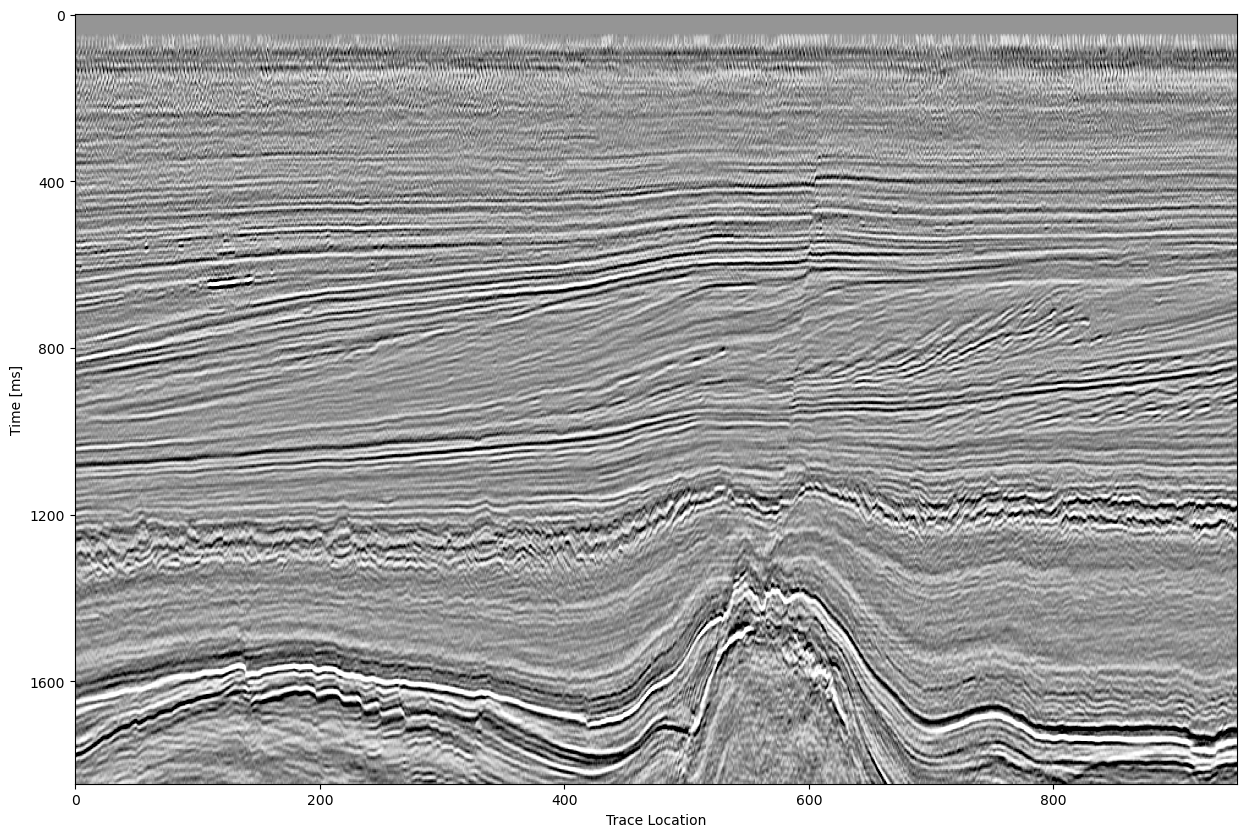

In [9]:
fig2 = plt.figure(figsize=(15.0, 10.0))
vml = np.percentile(labeled_data, 99)
img1 = plt.imshow(labeled_data, cmap="Greys", vmin=-vml, vmax=vml, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.show()

In [10]:
train_data, test_data, train_samples, test_samples = train_test_split(
    labels, sampler, random_state=42)
print(train_data.shape,test_data.shape)

(119109, 4) (39703, 4)


In [11]:
class SeismicSequence(Sequence):
    def __init__(self, img, x_set, t_set, y_set, patch_size, batch_size, dimensions):
        self.slice = img
        self.X,self.t = x_set,t_set
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.dimensions = dimensions
        self.label = y_set
    
    def __len__(self):
        return len(self.X) // self.batch_size
    
    def __getitem__(self,idx):
        sampler = np.random.permutation(len(self.X))
        samples = sampler[idx*self.batch_size:(idx+1)*self.batch_size]
        labels = keras.utils.to_categorical(self.label[samples], num_classes=9)
        if self.dimensions == 1:
            return np.expand_dims(np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), axis=3), labels
        else:
            return np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), labels

In [12]:
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(450, dtype=tf.float32))

In [13]:
def normal_prior(prior_std):
    """Defines normal distribution prior for Bayesian neural network."""

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
#        tfd = tfp.distributions
        dist = tfd.Normal(loc=tf.zeros(shape, dtype),
                          scale=dtype.as_numpy_dtype((prior_std)))
        batch_ndims = tf.size(input=dist.batch_shape_tensor())
        return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

    return prior_fn 

In [14]:
prior_std = 10 
prior_fn = normal_prior(prior_std) 

In [15]:
model_vanilla = Sequential()
model_vanilla.add(tfp.layers.Convolution2DFlipout(50, (5, 5), padding='same', input_shape=(patch_size,patch_size,1), strides=(4, 4),kernel_divergence_fn=kl_divergence_function, kernel_prior_fn=prior_fn, data_format="channels_last",name = 'conv_0'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(tfp.layers.Convolution2DFlipout(50, (3, 3), strides=(2, 2), padding = 'same',kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn,name = 'conv_1'))
#model_vanilla.add(Dropout(0.2))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(tfp.layers.Convolution2DFlipout(50, (3, 3), strides=(2, 2), padding= 'same',kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn,name = 'conv_2'))
#model_vanilla.add(Dropout(0.2))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(tfp.layers.Convolution2DFlipout(50, (3, 3), strides=(2, 2), padding= 'same',kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn,name = 'conv_3'))
#model_vanilla.add(Dropout(0.2))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(tfp.layers.Convolution2DFlipout(50, (3, 3), strides=(2, 2), padding= 'same',kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn,name = 'conv_4'))
model_vanilla.add(Flatten())
model_vanilla.add(tfp.layers.DenseFlipout(50,kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn, name = 'dense_0'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(tfp.layers.DenseFlipout(10,kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn, name = 'dense_1'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(tfp.layers.DenseFlipout(num_classes, kernel_divergence_fn=kl_divergence_function,kernel_prior_fn=prior_fn, name = 'dense_2'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('softmax'))

model_vanilla.summary(line_length=100)

/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv_0 (Conv2DFlipout)                      (None, 16, 16, 50)                      2550           
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 16, 16, 50)                      200            
                                                                                                    
 activation (Activation)                     (None, 16, 16, 50)                      0              
                                                                                                    
 conv_1 (Conv2DFlipout)                      (None, 8, 8, 50)                        45050          
                                                                       

In [17]:
from tensorflow.keras.callbacks import EarlyStopping



early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


model_vanilla.compile(loss=lossfkt,
                  optimizer=opt,
                  metrics=metrica, experimental_run_tf_function=False)

hist_vanilla = model_vanilla.fit(
    SeismicSequence(
        labeled_data,
        train_data["Xline"].values,
        train_data["Time"].values,
        train_data["Class"].values,
        patch_size,
        batch_size,
        1),
    steps_per_epoch=steps,
    validation_data = SeismicSequence(
        labeled_data,
        test_data["Xline"].values,
        test_data["Time"].values,
        test_data["Class"].values,
        patch_size,
        batch_size,
        1),
    validation_steps = len(test_samples)//batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks=[early_stop])

Epoch 1/10
250/250 [==============================] - 74s 231ms/step - loss: 988.1976 - mae: 0.1604 - acc: 0.4619 - val_loss: 962.6949 - val_mae: 0.1381 - val_acc: 0.4966
Epoch 2/10
250/250 [==============================] - 57s 228ms/step - loss: 937.0031 - mae: 0.1058 - acc: 0.7591 - val_loss: 911.6853 - val_mae: 0.0772 - val_acc: 0.7966
Epoch 3/10
250/250 [==============================] - 58s 233ms/step - loss: 886.8160 - mae: 0.0725 - acc: 0.8595 - val_loss: 861.9167 - val_mae: 0.0530 - val_acc: 0.8778
Epoch 4/10
250/250 [==============================] - 72s 288ms/step - loss: 837.5278 - mae: 0.0528 - acc: 0.9052 - val_loss: 813.1342 - val_mae: 0.0419 - val_acc: 0.8979
Epoch 5/10
250/250 [==============================] - 57s 227ms/step - loss: 789.2689 - mae: 0.0449 - acc: 0.9145 - val_loss: 765.4274 - val_mae: 0.0376 - val_acc: 0.9042
Epoch 6/10
250/250 [==============================] - 57s 228ms/step - loss: 742.1747 - mae: 0.0422 - acc: 0.9130 - val_loss: 719.0097 - val_mae:

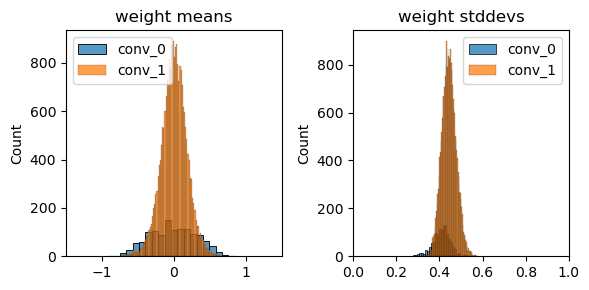

In [18]:
def plot_weight_posteriors(names, qm_vals, qs_vals):
    fig = plt.figure(figsize=(6, 3))
  
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names[0:2], qm_vals[0:2]):
        sns.histplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title('weight means')
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
  
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names[0:2], qs_vals[0:2]):
        sns.histplot(tf.reshape(qs, shape=[-1]), ax=ax, label=n)
    ax.set_title('weight stddevs')
    ax.set_xlim([0, 1.])
    ax.legend()
  
    fig.tight_layout()

names = [layer.name for layer in model_vanilla.layers if 'conv' in layer.name]
qm_vals = [layer.kernel_posterior.mean() for layer in model_vanilla.layers if 'conv' in layer.name]
qs_vals = [layer.kernel_posterior.stddev() for layer in model_vanilla.layers if 'conv' in layer.name]
plot_weight_posteriors(names, qm_vals, qs_vals)


In [19]:


test_generator = SeismicSequence(
    labeled_data,
    test_data["Xline"].values,
    test_data["Time"].values,
    test_data["Class"].values,
    patch_size,
    batch_size,
    1
)

test_results = model_vanilla.evaluate(test_generator, steps=len(test_samples)//batch_size)


print('Test Results:', test_results)

155/155 [==============================] - 22s 140ms/step - loss: 549.7919 - mae: 0.0525 - acc: 0.8362
Test Results: [549.7919311523438, 0.05248876288533211, 0.8361895084381104]


In [ ]:
# # Perform predictions on the test dataset
# predictions = model_vanilla.predict_generator(
#     SeismicSequence(
#         labeled_data,
#         test_data["Xline"].values,
#         test_data["Time"].values,
#         test_data["Class"].values,
#         patch_size,
#         batch_size,
#         1),
#     steps=len(test_samples) // batch_size)

# # Compute classification probabilities and uncertainties using Monte Carlo dropout
# num_mc_samples = 100  
# mc_predictions = []
# for _ in range(num_mc_samples):
#     mc_predictions.append(model_vanilla.predict_generator(
#         SeismicSequence(
#             labeled_data,
#             test_data["Xline"].values,
#             test_data["Time"].values,
#             test_data["Class"].values,
#             patch_size,
#             batch_size,
#             1),
#         steps=len(test_samples) // batch_size))
# mc_predictions = tf.stack(mc_predictions)

# # Compute classification probabilities and uncertainty
# classification_probabilities = tf.nn.softmax(mc_predictions, axis=-1)
# uncertainty = tf.reduce_mean(tf.math.reduce_std(classification_probabilities, axis=0), axis=-1)

# # Print the predicted classes and uncertainties
# for i in range (5):   #(len(test_samples)):
#     predicted_class = tf.argmax(tf.reduce_mean(classification_probabilities[:, i, :], axis=0))
#     predicted_uncertainty = uncertainty[i]
#     print(f"Sample {i + 1}: Class {predicted_class}, Uncertainty {predicted_uncertainty}")


In [ ]:
import matplotlib.pyplot as plt

# Perform predictions on the test dataset
predictions = model_vanilla.predict_generator(
    SeismicSequence(
        labeled_data,
        test_data["Xline"].values,
        test_data["Time"].values,
        test_data["Class"].values,
        patch_size,
        batch_size,
        1),
    steps=len(test_samples) // batch_size)

# Compute classification probabilities and uncertainties using Monte Carlo dropout
num_mc_samples = 100  
mc_predictions = []
for _ in range(num_mc_samples):
    mc_predictions.append(model_vanilla.predict_generator(
        SeismicSequence(
            labeled_data,
            test_data["Xline"].values,
            test_data["Time"].values,
            test_data["Class"].values,
            patch_size,
            batch_size,
            1),
        steps=len(test_samples) // batch_size))
mc_predictions = tf.stack(mc_predictions)

# Compute classification probabilities and uncertainty
classification_probabilities = tf.nn.softmax(mc_predictions, axis=-1)
uncertainty = tf.reduce_mean(tf.math.reduce_std(classification_probabilities, axis=0), axis=-1)

# Print the predicted classes and uncertainties
for i in range(1):
    sample_index = i + 1
    actual_class = test_data["Class"].values[i]
    predicted_class = tf.argmax(tf.reduce_mean(classification_probabilities[:, i, :], axis=0))
    predicted_uncertainty = uncertainty[i]
    
    # Get the actual and predicted images
    actual_image = labeled_data[test_samples[i]]
    predicted_image = predictions[i]
    
    # Display the images, class, and uncertainty
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(actual_image, cmap="Greys")
    ax1.set_title(f"Actual Image (Class {actual_class})")
    ax1.axis("off")
    
    ax2.imshow(predicted_image, cmap="Greys")
    ax2.set_title(f"Predicted Image (Class {predicted_class})\nUncertainty: {predicted_uncertainty:.4f}")
    ax2.axis("off")
    
    plt.show()


/tmp/ipykernel_28/1979643620.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_vanilla.predict_generator(
/tmp/ipykernel_28/1979643620.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  mc_predictions.append(model_vanilla.predict_generator(
